# Assignment #5: Boosting

In this assignment we will learn about gradient boosting.

## Write the code for gradient boosting of tree for solving binary classification problem from scratch

For the regression trees we will use Scikit-learn implementation. The trees have to be weak learners, so their depth has to be set to a small value. We will choose their final depth arbitrarily. We will also think about overfitting.

We start with a leaf that represents an initial Prediction for every individual. When we use Gradient Boost for Classification the initial Prediction for every individual is log(odds). For example 4 people have class Yes and 2 have class No, so log(odds) that someone is Yes is log(4/2), which we will put in the initial leaf as the initial prediction. To use it for classification we invert it to probability. Probability of Yes is (e^{log(4/2)} / (1 + e^{log(4/2)})). Since the probability of Yes is greater than 0.5 (or other threshold), we can Classify everyone in the training dataset as yes. For each sample we calculate the residuals (actual valia - probability). Now we build tree using the features to predict the residuals (minimum number of leaves 8 or 32). To get the output value in the leaf we need to do transformation (sum of all residuals in a leaf) / (sum of previously predicted probabilities for each residual times one minus the same probability). When we are on the first step the previous probabilities are the same for all residuals (initial prob). Update predictions by combining the initial leaf with the new tree and scaling it by learning rate (0.1 is common). Now log of the odds prediction for each person is previous prediction plut output value of the tree scaled by the learning rate. Then we convert it to probability. This continuours until we have made maximum number of trees, or the resudials get super small. When predicting we start with the initial value and add outputs from each tree by the learning rate and convert it into a prediction, we compare with the threshold and classify it.


In [2]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import roc_curve, auc

In [3]:
class GradientBoostingBinaryClassifier:
  def __init__(self, n_estimators=100, learning_rate=0.1, max_depth=3):
    # Maximum number of trees
    self.n_estimators = n_estimators
    # Learning rate by which we multiply the output value from each tree
    self.learning_rate = learning_rate
    # Maximum depth of the tree
    self.max_depth = max_depth
    # Array of trees
    self.trees = []
    # Initial prediction as probability
    self.initial_prediction = None


  def sigmoid(self, x):
    # Convert to probability
    return 1 / (1 + np.exp(-x))


  def fit(self, X, y):
    # Start with initial prediction for each sample as a probability
    initial_log_odds = np.log(np.mean(y) / (1 - np.mean(y)))
    self.initial_prediction = self.sigmoid(initial_log_odds)
    prev_predictions = np.full(y.shape, self.initial_prediction)

    for _ in range(self.n_estimators):
      # Compute the current residuals and check if they are small enough to stop the fitting
      residuals = y - prev_predictions

      # Fit a regression tree on the residuals
      tree = DecisionTreeRegressor(max_depth=self.max_depth).fit(X, residuals)
      self.trees.append(tree)

      # Update the predictions
      current_predictions = tree.predict(X)
      prev_predictions = self.sigmoid(prev_predictions + self.learning_rate * current_predictions)


  def predict(self, X, prediction_threshold=0.5):
    # Predict probabilities for the features by going thru each tree
    prev_predictions = np.full(X.shape[0], self.initial_prediction)
    for tree in self.trees:
      current_predictions = tree.predict(X)
      prev_predictions = prev_predictions + self.learning_rate * current_predictions

    prev_predictions = self.sigmoid(prev_predictions)
    return (prev_predictions >= prediction_threshold).astype(int), prev_predictions


  def evaluate(self, y_true, y_pred, y_scores):
    # Calculate TP, TN, FP, FN
    tp = sum((y_true == 1) & (y_pred == 1))
    tn = sum((y_true == 0) & (y_pred == 0))
    fp = sum((y_true == 0) & (y_pred == 1))
    fn = sum((y_true == 1) & (y_pred == 0))

    # Calculate the metrics
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    return accuracy, precision, recall, f1_score, fpr, tpr, roc_auc

## Download the dataset

The target variable here will be the column **quality**, which has values low and high.

In [4]:
import pandas as pd

In [9]:
wine_quality = pd.read_csv('data/wine_quality.csv', index_col=0)
wine_quality.head()

X  fixed.acidity  volatile.acidity  citric.acid  residual.sugar  chlorides  \
1  1            7.0              0.27         0.36            20.7      0.045   
2  2            6.3              0.30         0.34             1.6      0.049   
3  3            8.1              0.28         0.40             6.9      0.050   
4  4            7.2              0.23         0.32             8.5      0.058   
5  5            7.2              0.23         0.32             8.5      0.058   

   free.sulfur.dioxide  total.sulfur.dioxide  density    pH  sulphates  \
1                 45.0                 170.0   1.0010  3.00       0.45   
2                 14.0                 132.0   0.9940  3.30       0.49   
3                 30.0                  97.0   0.9951  3.26       0.44   
4                 47.0                 186.0   0.9956  3.19       0.40   
5                 47.0                 186.0   0.9956  3.19       0.40   

  quality alcohol_level  
1     low           low  
2     low           low  
3     low          high  
4     low           low  
5     low           low

As we can see the X column is just an index column so we can drop it.

In [10]:
wine_quality = wine_quality.drop('X', axis=1)
wine_quality

fixed.acidity  volatile.acidity  citric.acid  residual.sugar  chlorides  \
1               7.0              0.27         0.36            20.7      0.045   
2               6.3              0.30         0.34             1.6      0.049   
3               8.1              0.28         0.40             6.9      0.050   
4               7.2              0.23         0.32             8.5      0.058   
5               7.2              0.23         0.32             8.5      0.058   
...             ...               ...          ...             ...        ...   
4894            6.2              0.21         0.29             1.6      0.039   
4895            6.6              0.32         0.36             8.0      0.047   
4896            6.5              0.24         0.19             1.2      0.041   
4897            5.5              0.29         0.30             1.1      0.022   
4898            6.0              0.21         0.38             0.8      0.020   

      free.sulfur.dioxide  total.sulfur.dioxide  density    pH  sulphates  \
1                    45.0                 170.0  1.00100  3.00       0.45   
2                    14.0                 132.0  0.99400  3.30       0.49   
3                    30.0                  97.0  0.99510  3.26       0.44   
4                    47.0                 186.0  0.99560  3.19       0.40   
5                    47.0                 186.0  0.99560  3.19       0.40   
...                   ...                   ...      ...   ...        ...   
4894                 24.0                  92.0  0.99114  3.27       0.50   
4895                 57.0                 168.0  0.99490  3.15       0.46   
4896                 30.0                 111.0  0.99254  2.99       0.46   
4897                 20.0                 110.0  0.98869  3.34       0.38   
4898                 22.0                  98.0  0.98941  3.26       0.32   

     quality alcohol_level  
1        low           low  
2        low           low  
3        low          high  
4        low           low  
5        low           low  
...      ...           ...  
4894     low          high  
4895     low           low  
4896     low           low  
4897    high          high  
4898     low          high  

[4898 rows x 12 columns]

Let's now first encode the categorical columns **alcohol_level** and **quality**.

In [11]:
wine_quality['alcohol_level'].unique()

array(['low', 'high'], dtype=object)

In [12]:
wine_quality['alcohol_level'] = wine_quality['alcohol_level'].map({'high': 1, 'low': 0})
wine_quality['alcohol_level'].unique()

array([0, 1])

In [13]:
wine_quality['quality'].unique()

array(['low', 'high'], dtype=object)

In [14]:
wine_quality['quality'] = wine_quality['quality'].map({'high': 1, 'low': 0})
wine_quality['quality'].unique()

array([0, 1])

In [15]:
wine_quality.head()

fixed.acidity  volatile.acidity  citric.acid  residual.sugar  chlorides  \
1            7.0              0.27         0.36            20.7      0.045   
2            6.3              0.30         0.34             1.6      0.049   
3            8.1              0.28         0.40             6.9      0.050   
4            7.2              0.23         0.32             8.5      0.058   
5            7.2              0.23         0.32             8.5      0.058   

   free.sulfur.dioxide  total.sulfur.dioxide  density    pH  sulphates  \
1                 45.0                 170.0   1.0010  3.00       0.45   
2                 14.0                 132.0   0.9940  3.30       0.49   
3                 30.0                  97.0   0.9951  3.26       0.44   
4                 47.0                 186.0   0.9956  3.19       0.40   
5                 47.0                 186.0   0.9956  3.19       0.40   

   quality  alcohol_level  
1        0              0  
2        0              0  
3        0              1  
4        0              0  
5        0              0

Let's also check for missing values and duplicate rows.

In [16]:
wine_quality[wine_quality.duplicated()]

fixed.acidity  volatile.acidity  citric.acid  residual.sugar  chlorides  \
5               7.2              0.23         0.32             8.5      0.058   
6               8.1              0.28         0.40             6.9      0.050   
8               7.0              0.27         0.36            20.7      0.045   
9               6.3              0.30         0.34             1.6      0.049   
21              6.2              0.66         0.48             1.2      0.029   
...             ...               ...          ...             ...        ...   
4851            7.0              0.36         0.35             2.5      0.048   
4852            6.4              0.33         0.44             8.9      0.055   
4857            7.1              0.23         0.39            13.7      0.058   
4881            6.6              0.34         0.40             8.1      0.046   
4886            6.6              0.34         0.40             8.1      0.046   

      free.sulfur.dioxide  total.sulfur.dioxide  density    pH  sulphates  \
5                    47.0                 186.0  0.99560  3.19       0.40   
6                    30.0                  97.0  0.99510  3.26       0.44   
8                    45.0                 170.0  1.00100  3.00       0.45   
9                    14.0                 132.0  0.99400  3.30       0.49   
21                   29.0                  75.0  0.98920  3.33       0.39   
...                   ...                   ...      ...   ...        ...   
4851                 67.0                 161.0  0.99146  3.05       0.56   
4852                 52.0                 164.0  0.99488  3.10       0.48   
4857                 26.0                 172.0  0.99755  2.90       0.46   
4881                 68.0                 170.0  0.99494  3.15       0.50   
4886                 68.0                 170.0  0.99494  3.15       0.50   

      quality  alcohol_level  
5           0              0  
6           0              1  
8           0              0  
9           0              0  
21          1              1  
...       ...            ...  
4851        0              1  
4852        0              0  
4857        0              0  
4881        0              0  
4886        0              0  

[947 rows x 12 columns]

We can see that we have 947 duplicates so let's keep only one from each so we could have only unique rows.

In [17]:
wine_quality = wine_quality.drop_duplicates()
wine_quality[wine_quality.duplicated()]

Empty DataFrame
Columns: [fixed.acidity, volatile.acidity, citric.acid, residual.sugar, chlorides, free.sulfur.dioxide, total.sulfur.dioxide, density, pH, sulphates, quality, alcohol_level]
Index: []

Now let's check for missing values.

In [18]:
missing_ratio = wine_quality.isnull().mean()
missing_ratio = missing_ratio[missing_ratio > 0]
missing_ratio

Series([], dtype: float64)

In [23]:
wine_quality

fixed.acidity  volatile.acidity  citric.acid  residual.sugar  chlorides  \
1               7.0              0.27         0.36            20.7      0.045   
2               6.3              0.30         0.34             1.6      0.049   
3               8.1              0.28         0.40             6.9      0.050   
4               7.2              0.23         0.32             8.5      0.058   
7               6.2              0.32         0.16             7.0      0.045   
...             ...               ...          ...             ...        ...   
4894            6.2              0.21         0.29             1.6      0.039   
4895            6.6              0.32         0.36             8.0      0.047   
4896            6.5              0.24         0.19             1.2      0.041   
4897            5.5              0.29         0.30             1.1      0.022   
4898            6.0              0.21         0.38             0.8      0.020   

      free.sulfur.dioxide  total.sulfur.dioxide  density    pH  sulphates  \
1                    45.0                 170.0  1.00100  3.00       0.45   
2                    14.0                 132.0  0.99400  3.30       0.49   
3                    30.0                  97.0  0.99510  3.26       0.44   
4                    47.0                 186.0  0.99560  3.19       0.40   
7                    30.0                 136.0  0.99490  3.18       0.47   
...                   ...                   ...      ...   ...        ...   
4894                 24.0                  92.0  0.99114  3.27       0.50   
4895                 57.0                 168.0  0.99490  3.15       0.46   
4896                 30.0                 111.0  0.99254  2.99       0.46   
4897                 20.0                 110.0  0.98869  3.34       0.38   
4898                 22.0                  98.0  0.98941  3.26       0.32   

      quality  alcohol_level  
1           0              0  
2           0              0  
3           0              1  
4           0              0  
7           0              0  
...       ...            ...  
4894        0              1  
4895        0              0  
4896        0              0  
4897        1              1  
4898        0              1  

[3951 rows x 12 columns]

The dataset doesn't have missing values and it now seems to be ready for splitting it into a training a test set of dependent and independent attributes.

In [25]:
X = wine_quality.drop('quality', axis=1).values
y = wine_quality['quality'].values

In [26]:
X

array([[7.  , 0.27, 0.36, ..., 3.  , 0.45, 0.  ],
       [6.3 , 0.3 , 0.34, ..., 3.3 , 0.49, 0.  ],
       [8.1 , 0.28, 0.4 , ..., 3.26, 0.44, 1.  ],
       ...,
       [6.5 , 0.24, 0.19, ..., 2.99, 0.46, 0.  ],
       [5.5 , 0.29, 0.3 , ..., 3.34, 0.38, 1.  ],
       [6.  , 0.21, 0.38, ..., 3.26, 0.32, 1.  ]])

In [27]:
y

array([0, 0, 0, ..., 0, 1, 0])

In [28]:
from sklearn.model_selection import train_test_split

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Evaluation of the implementation

Test different learning rates and find out, which are good. Test also different number of trees that are build during gradient boosting and comment on the results. Does our model overfit? If yes, how to prevent it?

In [30]:
from tqdm import tqdm

In [31]:
learning_rates = [0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1]
n_estimators = [50, 100, 200, 500, 1000]
max_depths = [3, 5, 7]
prediction_thresholds = [0.5, 0.6, 0.7, 0.8, 0.9]

In [36]:
results = []

for lr in tqdm(learning_rates, desc='Learning Rates'):
  for n_estimator in n_estimators:
    for max_depth in max_depths:
      # Initialize the model
      model = GradientBoostingBinaryClassifier(
          n_estimators = n_estimator,
          learning_rate = lr,
          max_depth = max_depth
      )

      # Fit the model and make predictions
      model.fit(X_train, y_train)
      for threshold in prediction_thresholds:
        y_pred, y_scores = model.predict(X_test, threshold)

        # Evaluate the model
        accuracy, precision, recall, f1_score, fpr, tpr, roc_auc = model.evaluate(y_test, y_pred, y_scores)
        results.append((lr, n_estimator, max_depth, threshold, accuracy, precision, recall, f1_score, fpr, tpr, roc_auc))

Learning Rates: 100%|██████████| 10/10 [10:39<00:00, 63.94s/it]


In [41]:
results_df = pd.DataFrame(results, columns=['Learning Rate', 'Num Estimators', 'Max Depth', 'Threshold', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'FPR', 'TPR', 'AUC'])
results_df = results_df.drop(['FPR', 'TPR'], axis=1)
results_df

Learning Rate  Num Estimators  Max Depth  Threshold  Accuracy  Precision  \
0            0.001              50          3        0.5  0.208597   0.208597   
1            0.001              50          3        0.6  0.791403   0.000000   
2            0.001              50          3        0.7  0.791403   0.000000   
3            0.001              50          3        0.8  0.791403   0.000000   
4            0.001              50          3        0.9  0.791403   0.000000   
..             ...             ...        ...        ...       ...        ...   
745          1.000            1000          7        0.5  0.821745   0.760870   
746          1.000            1000          7        0.6  0.821745   0.760870   
747          1.000            1000          7        0.7  0.819216   0.750000   
748          1.000            1000          7        0.8  0.819216   0.750000   
749          1.000            1000          7        0.9  0.816688   0.738095   

       Recall  F1-Score       AUC  
0    1.000000  0.345188  0.776474  
1    0.000000  0.000000  0.776474  
2    0.000000  0.000000  0.776474  
3    0.000000  0.000000  0.776474  
4    0.000000  0.000000  0.776474  
..        ...       ...       ...  
745  0.212121  0.331754  0.802812  
746  0.212121  0.331754  0.802812  
747  0.200000  0.315789  0.802812  
748  0.200000  0.315789  0.802812  
749  0.187879  0.299517  0.802812  

[750 rows x 9 columns]

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

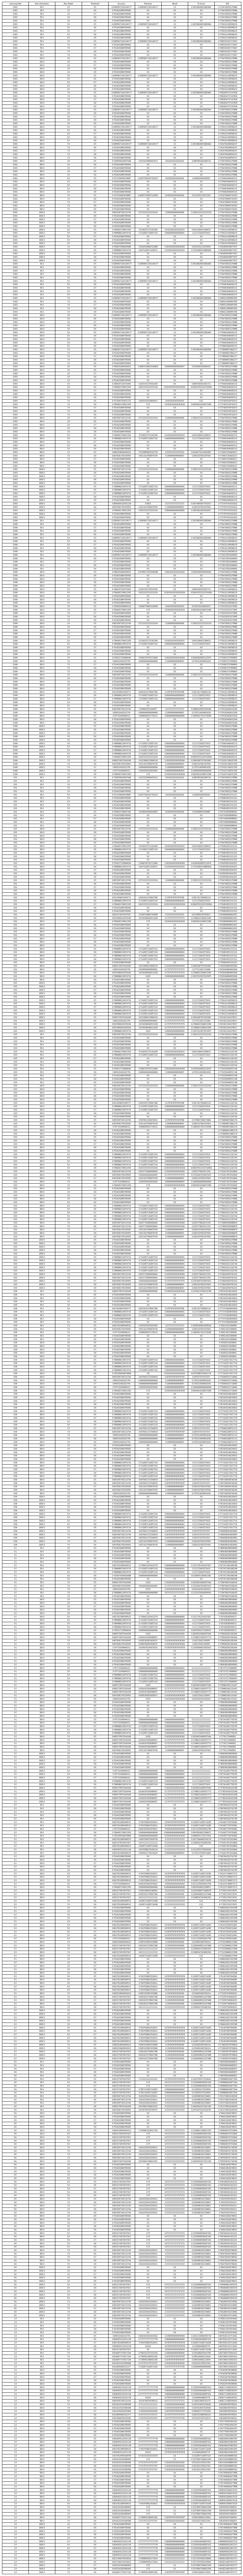

In [43]:
fig, ax = plt.subplots(figsize=(15, 10))
ax.axis('tight')
ax.axis('off')
ax.table(cellText=results_df.values, colLabels=results_df.columns, cellLoc = 'center', loc='center')

plt.show()

We can see that we got a lot of values here so let's check the mean results for each metric from each parameter.

In [44]:
results_df.groupby('Learning Rate').mean().iloc[:, 3:]

Accuracy  Precision    Recall  F1-Score       AUC
Learning Rate                                                   
0.001          0.720051   0.080826  0.161131  0.082039  0.772387
0.003          0.745369   0.155648  0.132202  0.089898  0.775048
0.006          0.770097   0.239248  0.108525  0.101217  0.775582
0.010          0.793814   0.281703  0.083394  0.106953  0.772101
0.030          0.797488   0.370710  0.077576  0.118350  0.775497
0.060          0.798432   0.421621  0.075636  0.121724  0.776742
0.100          0.798449   0.427942  0.072000  0.118561  0.784220
0.300          0.798163   0.452333  0.069333  0.117764  0.783205
0.600          0.799461   0.464581  0.074667  0.125821  0.791538
1.000          0.804062   0.508951  0.090990  0.150521  0.801329

By simply comparing the mean of just the learning rate we can see that the scores are getting better with increasing of the values. The Accuracy and AUC are two main metrics. We can see that after value 0.006 the Accuracy doesn't increase much, while the Precision continuous getting better. Also the F1-Score, which help us balance btw Precision and Recall has the highest value for learning rate 1. The AUC starts increasing more rapidly after value 0.06.

In [45]:
results_df.groupby('Num Estimators').mean().iloc[:, 3:]

Accuracy  Precision    Recall  F1-Score       AUC
Num Estimators                                                   
50              0.759621   0.250247  0.116768  0.100214  0.780902
100             0.772347   0.309738  0.103919  0.107279  0.780892
200             0.784998   0.353138  0.093172  0.115156  0.780751
500             0.797084   0.371098  0.082343  0.121228  0.780670
1000            0.798643   0.417561  0.076525  0.122547  0.780608

We can see that increasing the number of trees also gives better mean scores, which is expected because it would mean that we predict the value by going thru more trees, which estimates it better. Anyway it doesn't really change the AUC scores. Also the Accuracy don't change much after using more than 100 estimators.

In [46]:
results_df.groupby('Max Depth').mean().iloc[:, 3:]

Accuracy  Precision    Recall  F1-Score       AUC
Max Depth                                                   
3          0.777461   0.035091  0.042715  0.030091  0.781365
5          0.783054   0.521700  0.090424  0.111932  0.784442
7          0.787100   0.464278  0.150497  0.197832  0.776488

Changing the depth of the trees changes the scores, but not very much, which is why it is better to use more but simples trees. Using too deep trees even starts decreasing the AUC score as we can see.

In [47]:
results_df.groupby('Threshold').mean().iloc[:, 3:]

Accuracy  Precision    Recall  F1-Score       AUC
Threshold                                                   
0.5        0.725689   0.445961  0.277455  0.239423  0.780765
0.6        0.798180   0.388309  0.063596  0.105476  0.780765
0.7        0.797008   0.324092  0.051273  0.085876  0.780765
0.8        0.796157   0.277480  0.043232  0.072714  0.780765
0.9        0.795660   0.265941  0.037172  0.062935  0.780765

Changing the threshold don't really seem to change the AUC score, which is expected since the AUC score is not calculated on the predictions but on the probabilities. Anyway, we can see that the accuracy doesn't change much after threshold 0.6 and the F1-score seems to be falling when increasing the threshold.

Now, when we have some idea how different parameters change the mean scores, let's find, which are the parameters that give best and worst scores for each metric.

In [48]:
best_params_idx = results_df['Accuracy'].idxmax()
best_params = results_df.iloc[best_params_idx]
worst_params_idx = results_df['Precision'].idxmin()
worst_params = results_df.iloc[worst_params_idx]
print("Best Parameters:\n", best_params)
print("Worst Parameters:\n", worst_params)

Best Parameters:
 Learning Rate        1.000000
Num Estimators    1000.000000
Max Depth            7.000000
Threshold            0.500000
Accuracy             0.821745
Precision            0.760870
Recall               0.212121
F1-Score             0.331754
AUC                  0.802812
Name: 745, dtype: float64
Worst Parameters:
 Learning Rate      0.001000
Num Estimators    50.000000
Max Depth          3.000000
Threshold          0.600000
Accuracy           0.791403
Precision          0.000000
Recall             0.000000
F1-Score           0.000000
AUC                0.776474
Name: 1, dtype: float64


In [49]:
best_params_idx = results_df['F1-Score'].idxmax()
best_params = results_df.iloc[best_params_idx]
worst_params_idx = results_df['F1-Score'].idxmin()
worst_params = results_df.iloc[worst_params_idx]
print("Best Parameters:\n", best_params)
print("Worst Parameters:\n", worst_params)

Best Parameters:
 Learning Rate       0.003000
Num Estimators    200.000000
Max Depth           7.000000
Threshold           0.500000
Accuracy            0.757269
Precision           0.442553
Recall              0.630303
F1-Score            0.520000
AUC                 0.773783
Name: 115, dtype: float64
Worst Parameters:
 Learning Rate      0.001000
Num Estimators    50.000000
Max Depth          3.000000
Threshold          0.600000
Accuracy           0.791403
Precision          0.000000
Recall             0.000000
F1-Score           0.000000
AUC                0.776474
Name: 1, dtype: float64


In [50]:
best_params_idx = results_df['AUC'].idxmax()
best_params = results_df.iloc[best_params_idx]
worst_params_idx = results_df['AUC'].idxmin()
worst_params = results_df.iloc[worst_params_idx]
print("Best Parameters:\n", best_params)
print("Worst Parameters:\n", worst_params)

Best Parameters:
 Learning Rate        1.000000
Num Estimators    1000.000000
Max Depth            5.000000
Threshold            0.500000
Accuracy             0.804046
Precision            0.777778
Recall               0.084848
F1-Score             0.153005
AUC                  0.808660
Name: 740, dtype: float64
Worst Parameters:
 Learning Rate       0.001000
Num Estimators    500.000000
Max Depth           7.000000
Threshold           0.500000
Accuracy            0.747155
Precision           0.428571
Recall              0.636364
F1-Score            0.512195
AUC                 0.761676
Name: 55, dtype: float64


In general, it seems that if we are focused on AUC and Accuracy we should use the combination of **learning rate** 1, **number of estimators** 1000, **maximum depth of trees** 7, and **prediction threshold** 0.5. Anyway, using **learning rate** 0.003, **number of estimators** 200 instead, give us better F1-Score and performance, but decreases drastically the Accuracy and the AUC.

## Evaluate using Cross-Validation

Compare cross-validation results from our implementation with the "GradientBoostingClassifier" classifier implemented in Scikit-Learn.

In [52]:
from sklearn.model_selection import KFold
from sklearn.ensemble import GradientBoostingClassifier

In [53]:
n_splits = 10
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

In [68]:
acc_custom, f1_custom, fpr_custom, tpr_custom, auc_custom = [], [], [], [], []
acc_sklearn, f1_sklearn, fpr_sklearn, tpr_sklearn, auc_sklearn = [], [], [], [], []

for train_idx, test_idx in tqdm(kf.split(X), total=kf.get_n_splits(), desc="KFold Progress"):
  # Split the data
  X_train, X_test = X[train_idx], X[test_idx]
  y_train, y_test = y[train_idx], y[test_idx]

  # Train and evaluate the custom boosting
  custom_boosting = GradientBoostingBinaryClassifier(n_estimators=1000, learning_rate=1, max_depth=7)
  custom_boosting.fit(X_train, y_train)
  y_pred_custom, y_scores_custom = custom_boosting.predict(X_test)
  accuracy, precision, recall, f1_score, fpr, tpr, roc_auc = custom_boosting.evaluate(y_test, y_pred_custom, y_scores_custom)
  acc_custom.append(accuracy)
  f1_custom.append(f1_score)
  fpr_custom.append(fpr)
  tpr_custom.append(tpr)
  auc_custom.append(roc_auc)

  # Train and evaluate the scikit-learn boosting
  sklearn_boosting = GradientBoostingClassifier(n_estimators=1000, learning_rate=1, max_depth=7)
  sklearn_boosting.fit(X_train, y_train)
  y_pred_sklearn = sklearn_boosting.predict(X_test)
  y_scores_sklearn = sklearn_boosting.decision_function(X_test)
  accuracy, precision, recall, f1_score, fpr, tpr, roc_auc = custom_boosting.evaluate(y_test, y_pred_sklearn, y_scores_sklearn)
  acc_sklearn.append(accuracy)
  f1_sklearn.append(f1_score)
  fpr_sklearn.append(fpr)
  tpr_sklearn.append(tpr)
  auc_sklearn.append(roc_auc)

KFold Progress: 100%|██████████| 10/10 [03:28<00:00, 20.87s/it]


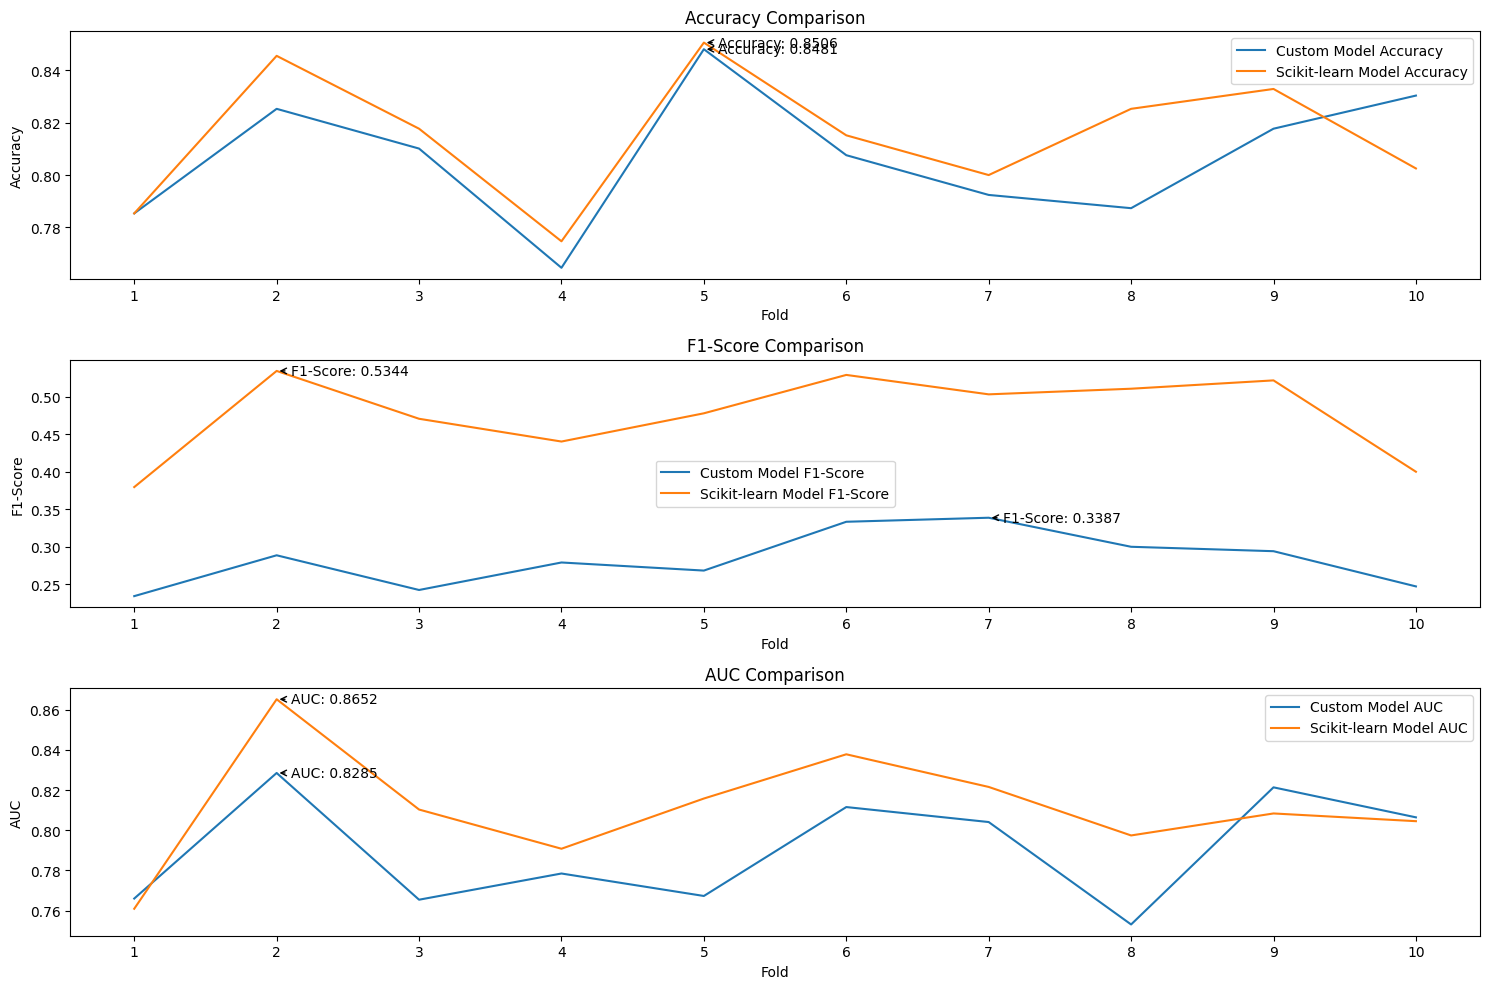

In [69]:
metrics_custom = [acc_custom, f1_custom, auc_custom]
metrics_sklearn = [acc_sklearn, f1_sklearn, auc_sklearn]
metric_names = ['Accuracy', 'F1-Score', 'AUC']

fig, axes = plt.subplots(3, 1, figsize=(15, 10))

for i, ax in enumerate(axes.flatten()):
  x_data = range(1, len(metrics_custom[i]) + 1)
  ax.plot(x_data, metrics_custom[i], label='Custom Model ' + metric_names[i])
  ax.plot(x_data, metrics_sklearn[i], label='Scikit-learn Model ' + metric_names[i])

  # Determine the best value for custom model
  best_idx_custom = np.argmax(metrics_custom[i])
  best_value_custom = metrics_custom[i][best_idx_custom]

  # Determine the best value for sklearn model
  best_idx_sklearn = np.argmax(metrics_sklearn[i])
  best_value_sklearn = metrics_sklearn[i][best_idx_sklearn]

  # Annotate the best value for custom model
  ax.annotate(f"{metric_names[i]}: {best_value_custom:.4f}",
              xy=(best_idx_custom + 1, best_value_custom),
              xytext=(10, 0), textcoords='offset points',
              arrowprops=dict(arrowstyle="->", connectionstyle="arc3"),
              ha='left', va='center')

  # Annotate the best value for sklearn model
  ax.annotate(f"{metric_names[i]}: {best_value_sklearn:.4f}",
              xy=(best_idx_sklearn + 1, best_value_sklearn),
              xytext=(10, 0), textcoords='offset points',
              arrowprops=dict(arrowstyle="->", connectionstyle="arc3"),
              ha='left', va='center')

  ax.set_xticks(x_data)
  ax.set_title(f'{metric_names[i]} Comparison')
  ax.set_xlabel('Fold')
  ax.set_ylabel(metric_names[i])
  ax.legend()

plt.tight_layout()
plt.show()

We can see that for the first combination of parameters our model has pretty worse F1-score compared to the Scikit-Learn implementation. The AUC is also lower, but not for all splits. The Accuracy seems to be also lower for our implementation, but has very close results for almost every split.

Now let's plot the ROC Curves for each model for all the CV splits to visualize the AUC scores shown in the last plot.

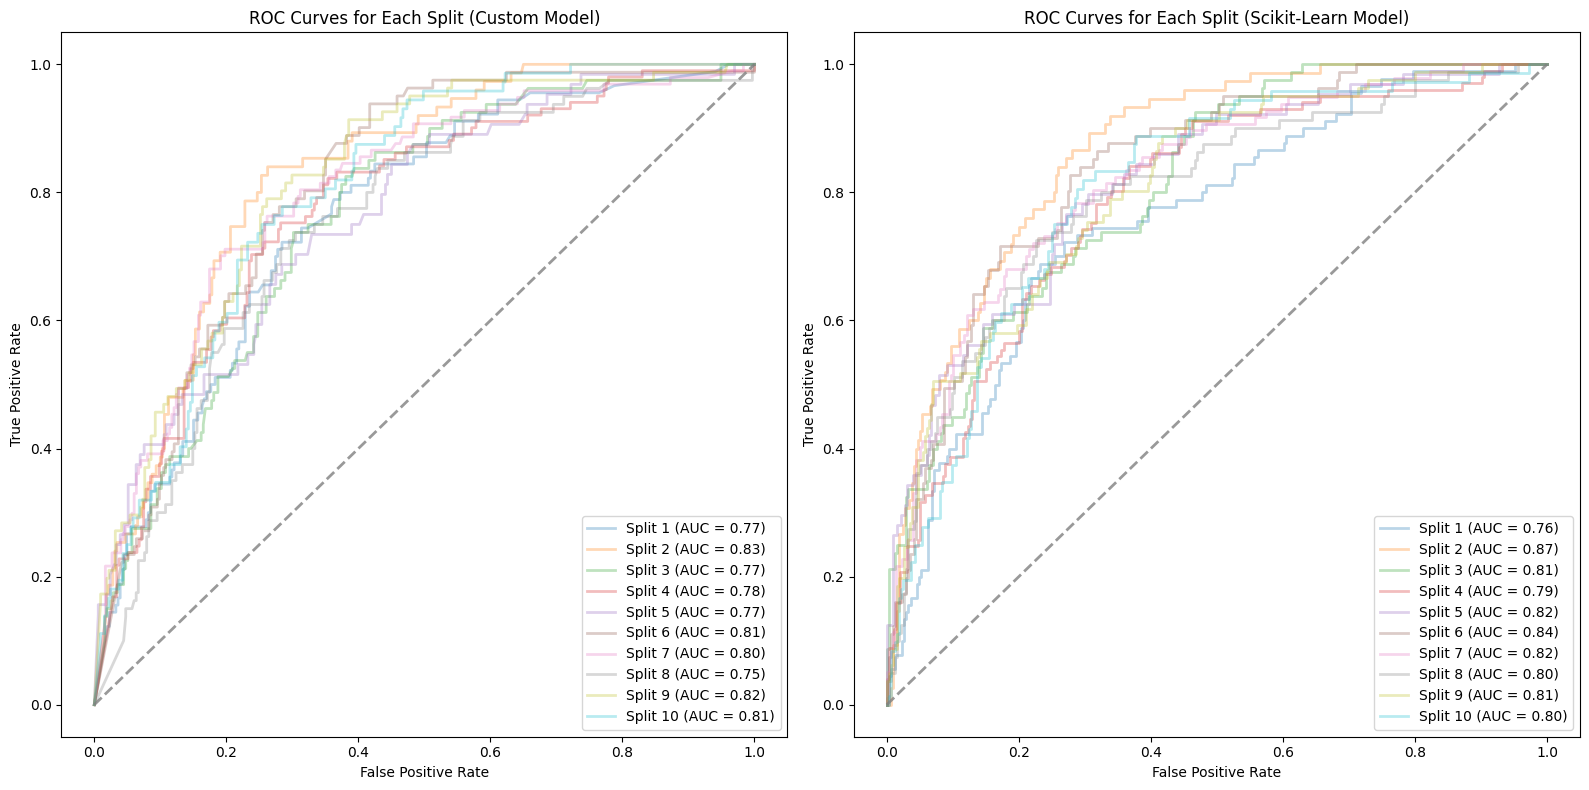

In [70]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Plotting for the custom model
for i, (fpr, tpr) in enumerate(zip(fpr_custom, tpr_custom)):
    roc_auc = auc(fpr, tpr)
    ax1.plot(fpr, tpr, lw=2, alpha=0.3, label=f'Split {i+1} (AUC = {roc_auc:.2f})')

ax1.plot([0, 1], [0, 1], linestyle='--', lw=2, color='gray', alpha=0.8)
ax1.set_title('ROC Curves for Each Split (Custom Model)')
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.legend(loc="lower right")

# Plotting for the scikit-learn model
for i, (fpr, tpr) in enumerate(zip(fpr_sklearn, tpr_sklearn)):
    roc_auc = auc(fpr, tpr)
    ax2.plot(fpr, tpr, lw=2, alpha=0.3, label=f'Split {i+1} (AUC = {roc_auc:.2f})')

ax2.plot([0, 1], [0, 1], linestyle='--', lw=2, color='gray', alpha=0.8)
ax2.set_title('ROC Curves for Each Split (Scikit-Learn Model)')
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.legend(loc="lower right")

plt.tight_layout()
plt.show()

We can see that visually the ROC curves are not so different.

Now let's see what happens if we use the other combination of parameters, which focuses on f1-score and performance.

In [71]:
acc_custom, f1_custom, fpr_custom, tpr_custom, auc_custom = [], [], [], [], []
acc_sklearn, f1_sklearn, fpr_sklearn, tpr_sklearn, auc_sklearn = [], [], [], [], []

for train_idx, test_idx in tqdm(kf.split(X), total=kf.get_n_splits(), desc="KFold Progress"):
  # Split the data
  X_train, X_test = X[train_idx], X[test_idx]
  y_train, y_test = y[train_idx], y[test_idx]

  # Train and evaluate the custom boosting
  custom_boosting = GradientBoostingBinaryClassifier(n_estimators=200, learning_rate=0.003, max_depth=7)
  custom_boosting.fit(X_train, y_train)
  y_pred_custom, y_scores_custom = custom_boosting.predict(X_test)
  accuracy, precision, recall, f1_score, fpr, tpr, roc_auc = custom_boosting.evaluate(y_test, y_pred_custom, y_scores_custom)
  acc_custom.append(accuracy)
  f1_custom.append(f1_score)
  fpr_custom.append(fpr)
  tpr_custom.append(tpr)
  auc_custom.append(roc_auc)

  # Train and evaluate the scikit-learn boosting
  sklearn_boosting = GradientBoostingClassifier(n_estimators=200, learning_rate=0.003, max_depth=7)
  sklearn_boosting.fit(X_train, y_train)
  y_pred_sklearn = sklearn_boosting.predict(X_test)
  y_scores_sklearn = sklearn_boosting.decision_function(X_test)
  accuracy, precision, recall, f1_score, fpr, tpr, roc_auc = custom_boosting.evaluate(y_test, y_pred_sklearn, y_scores_sklearn)
  acc_sklearn.append(accuracy)
  f1_sklearn.append(f1_score)
  fpr_sklearn.append(fpr)
  tpr_sklearn.append(tpr)
  auc_sklearn.append(roc_auc)

KFold Progress: 100%|██████████| 10/10 [01:24<00:00,  8.44s/it]


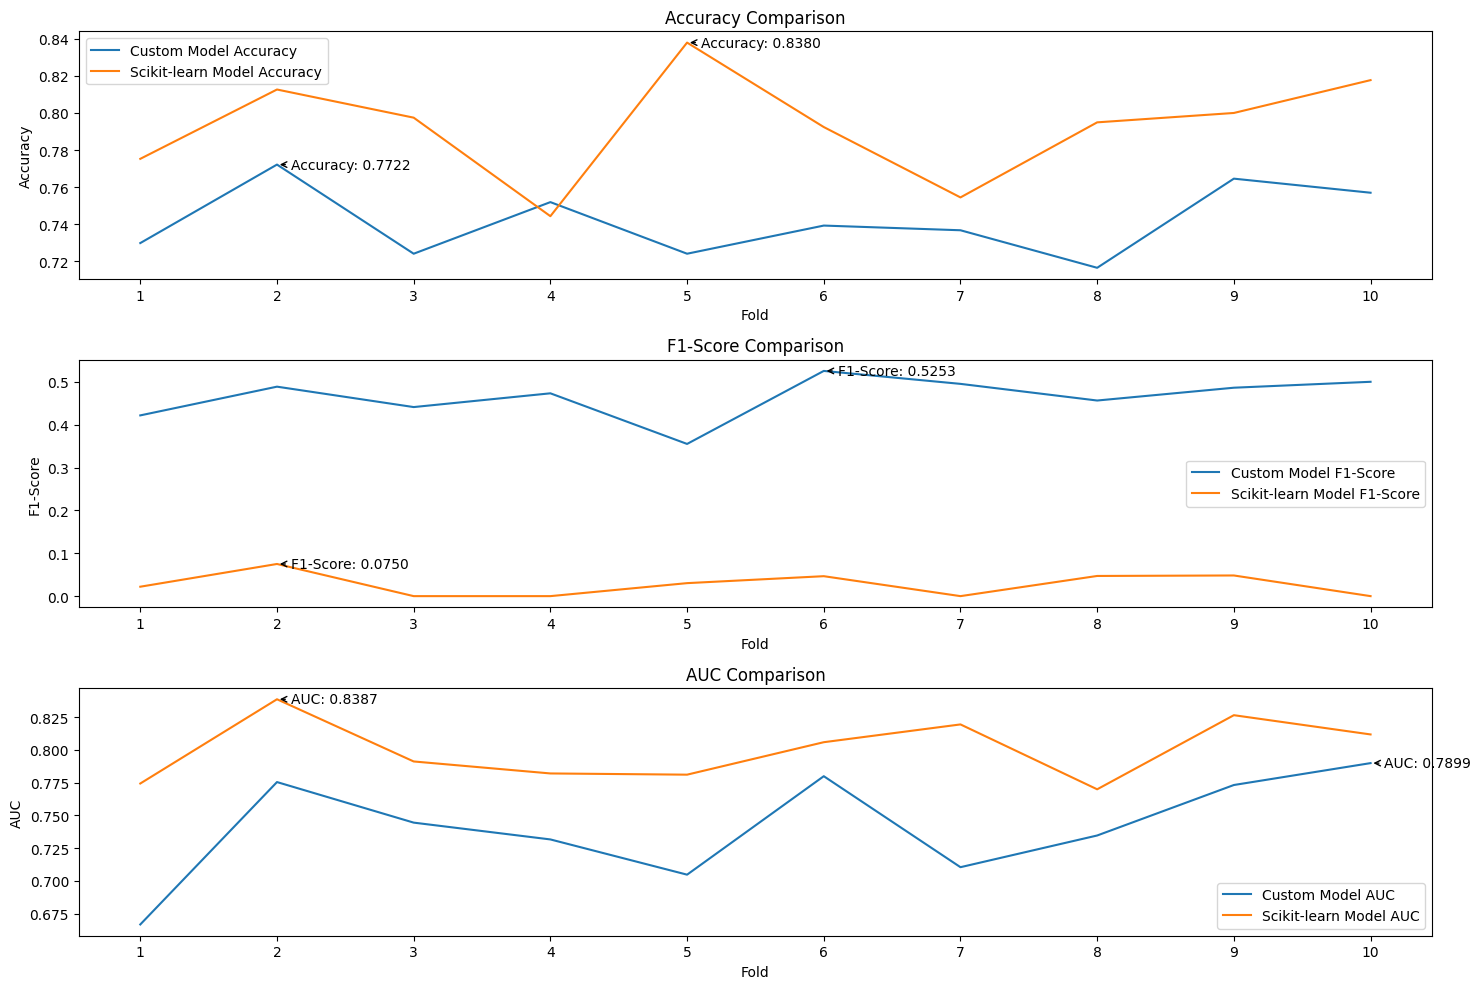

In [72]:
metrics_custom = [acc_custom, f1_custom, auc_custom]
metrics_sklearn = [acc_sklearn, f1_sklearn, auc_sklearn]
metric_names = ['Accuracy', 'F1-Score', 'AUC']

fig, axes = plt.subplots(3, 1, figsize=(15, 10))

for i, ax in enumerate(axes.flatten()):
  x_data = range(1, len(metrics_custom[i]) + 1)
  ax.plot(x_data, metrics_custom[i], label='Custom Model ' + metric_names[i])
  ax.plot(x_data, metrics_sklearn[i], label='Scikit-learn Model ' + metric_names[i])

  # Determine the best value for custom model
  best_idx_custom = np.argmax(metrics_custom[i])
  best_value_custom = metrics_custom[i][best_idx_custom]

  # Determine the best value for sklearn model
  best_idx_sklearn = np.argmax(metrics_sklearn[i])
  best_value_sklearn = metrics_sklearn[i][best_idx_sklearn]

  # Annotate the best value for custom model
  ax.annotate(f"{metric_names[i]}: {best_value_custom:.4f}",
              xy=(best_idx_custom + 1, best_value_custom),
              xytext=(10, 0), textcoords='offset points',
              arrowprops=dict(arrowstyle="->", connectionstyle="arc3"),
              ha='left', va='center')

  # Annotate the best value for sklearn model
  ax.annotate(f"{metric_names[i]}: {best_value_sklearn:.4f}",
              xy=(best_idx_sklearn + 1, best_value_sklearn),
              xytext=(10, 0), textcoords='offset points',
              arrowprops=dict(arrowstyle="->", connectionstyle="arc3"),
              ha='left', va='center')

  ax.set_xticks(x_data)
  ax.set_title(f'{metric_names[i]} Comparison')
  ax.set_xlabel('Fold')
  ax.set_ylabel(metric_names[i])
  ax.legend()

plt.tight_layout()
plt.show()

We see that in this case the accuracy of our model is not so close to the one from scikit. Also, as expected, the AUC is constantly lower, but the F1-score has drastically increased and is a lot better for our implementation for all splits.

Now let's see also here what ROC curves look like.

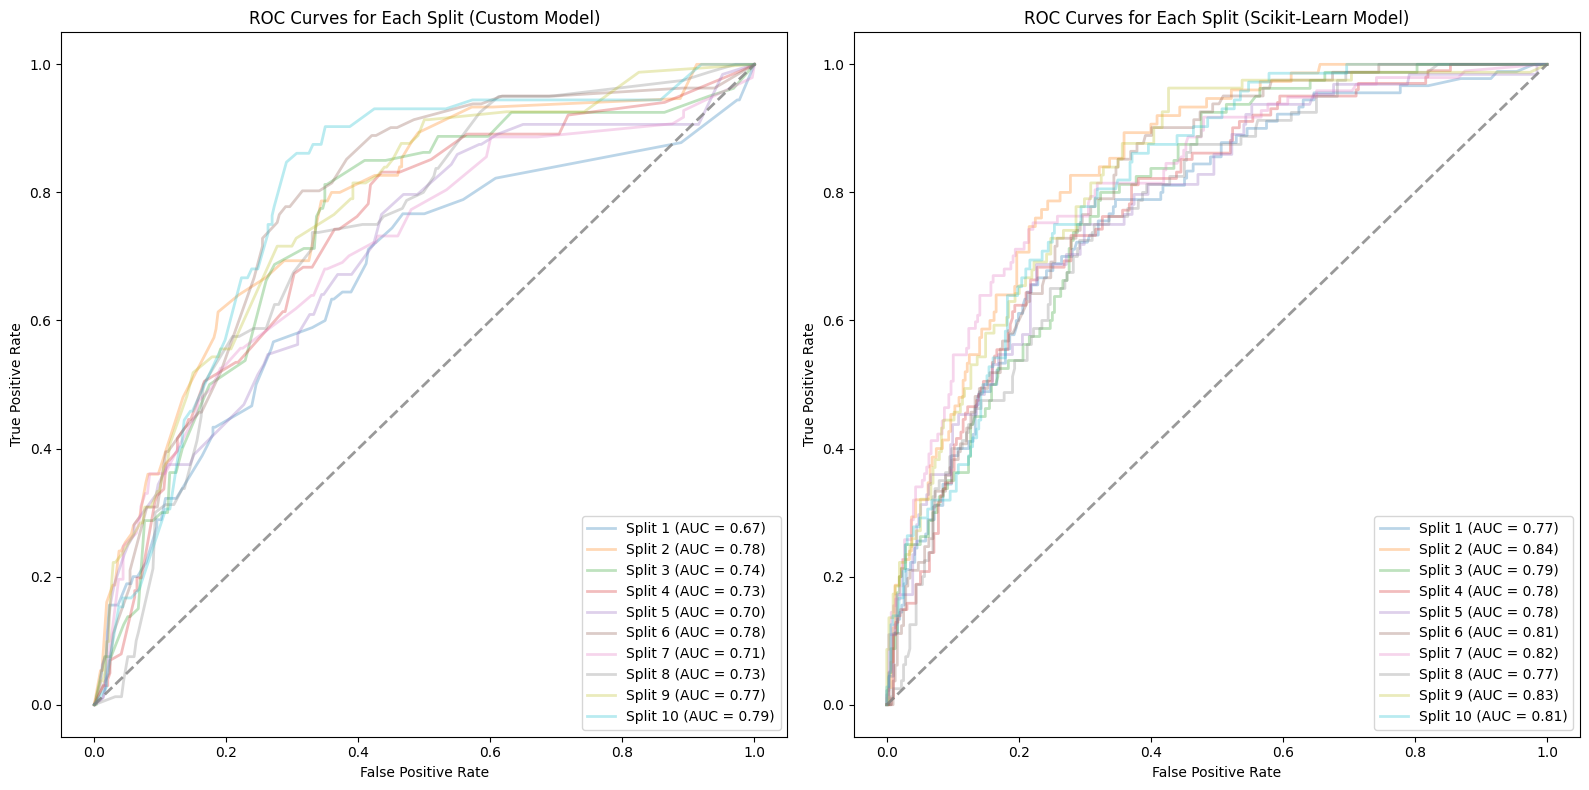

In [73]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Plotting for the custom model
for i, (fpr, tpr) in enumerate(zip(fpr_custom, tpr_custom)):
    roc_auc = auc(fpr, tpr)
    ax1.plot(fpr, tpr, lw=2, alpha=0.3, label=f'Split {i+1} (AUC = {roc_auc:.2f})')

ax1.plot([0, 1], [0, 1], linestyle='--', lw=2, color='gray', alpha=0.8)
ax1.set_title('ROC Curves for Each Split (Custom Model)')
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.legend(loc="lower right")

# Plotting for the scikit-learn model
for i, (fpr, tpr) in enumerate(zip(fpr_sklearn, tpr_sklearn)):
    roc_auc = auc(fpr, tpr)
    ax2.plot(fpr, tpr, lw=2, alpha=0.3, label=f'Split {i+1} (AUC = {roc_auc:.2f})')

ax2.plot([0, 1], [0, 1], linestyle='--', lw=2, color='gray', alpha=0.8)
ax2.set_title('ROC Curves for Each Split (Scikit-Learn Model)')
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.legend(loc="lower right")

plt.tight_layout()
plt.show()

## Try modelling with XGBoost, LightGBM, CatBoost models

Fit all tree models and evaluate them on the same test set.

In [74]:
!pip install xgboost lightgbm catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 5.3 MB/s eta 0:00:00


In [76]:
import xgboost as xgb
import lightgbm as lgb
import catboost as cb

# XGBoost model => eXtreme Gradient Boosting (control overfitting and make it robust)
xgb_model = xgb.XGBClassifier()
xgb_model.fit(X_train, y_train)

# LightGBM model => Light Gradient Boosting Machine (grows trees leaf-wise as opposed to level-wise)
lgb_model = lgb.LGBMClassifier()
lgb_model.fit(X_train, y_train)

# CatBoost model => Category Boosting (particulary effective with categorical data)
cb_model = cb.CatBoostClassifier(verbose=0)
cb_model.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 749, number of negative: 2807
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000785 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1259
[LightGBM] [Info] Number of data points in the train set: 3556, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.210630 -> initscore=-1.321133
[LightGBM] [Info] Start training from score -1.321133


In [88]:
def evaluate(y_true, y_pred, y_scores):
  # Calculate TP, TN, FP, FN
  tp = sum((y_true == 1) & (y_pred == 1))
  tn = sum((y_true == 0) & (y_pred == 0))
  fp = sum((y_true == 0) & (y_pred == 1))
  fn = sum((y_true == 1) & (y_pred == 0))

  # Calculate the metrics
  accuracy = (tp + tn) / (tp + tn + fp + fn)
  precision = tp / (tp + fp) if (tp + fp) > 0 else 0
  recall = tp / (tp + fn) if (tp + fn) > 0 else 0
  f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
  fpr, tpr, _ = roc_curve(y_true, y_scores)
  roc_auc = auc(fpr, tpr)

  return (accuracy, precision, recall, f1_score, roc_auc), (fpr, tpr, roc_auc)

In [93]:
y_pred_xgb = xgb_model.predict(X_test)
y_scores_xgb = xgb_model.predict_proba(X_test)[:, 1]
metrics_xgb, roc_data_xgb = evaluate(y_test, y_pred_xgb, y_scores_xgb)

y_pred_lgb = lgb_model.predict(X_test)
y_scores_lgb = lgb_model.predict_proba(X_test)[:, 1]
metrics_lgb, roc_data_lgb = evaluate(y_test, y_pred_lgb, y_scores_lgb)

y_pred_cb = cb_model.predict(X_test)
y_scores_cb = cb_model.predict_proba(X_test)[:, 1]
metrics_cb, roc_data_cb = evaluate(y_test, y_pred_cb, y_scores_cb)

In [94]:
results = pd.DataFrame([metrics_xgb, metrics_lgb, metrics_cb],
                       columns=['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC'],
                       index=['XGBoost', 'LightGBM', 'CatBoost'])
results

Accuracy  Precision    Recall  F1-Score       AUC
XGBoost   0.815190   0.492063  0.430556  0.459259  0.807921
LightGBM  0.817722   0.500000  0.388889  0.437500  0.813381
CatBoost  0.817722   0.500000  0.347222  0.409836  0.811017

We can see that the main difference in the models is seen in the Recall, and therefore the F1-Score, where the XGBoost seem to have highest value, after it is the LightGBM and worse CatBoost. Anyway, when we look at AUC eventhough with small difference the XGBoost seem to be the worst model. Let's also plot that information.

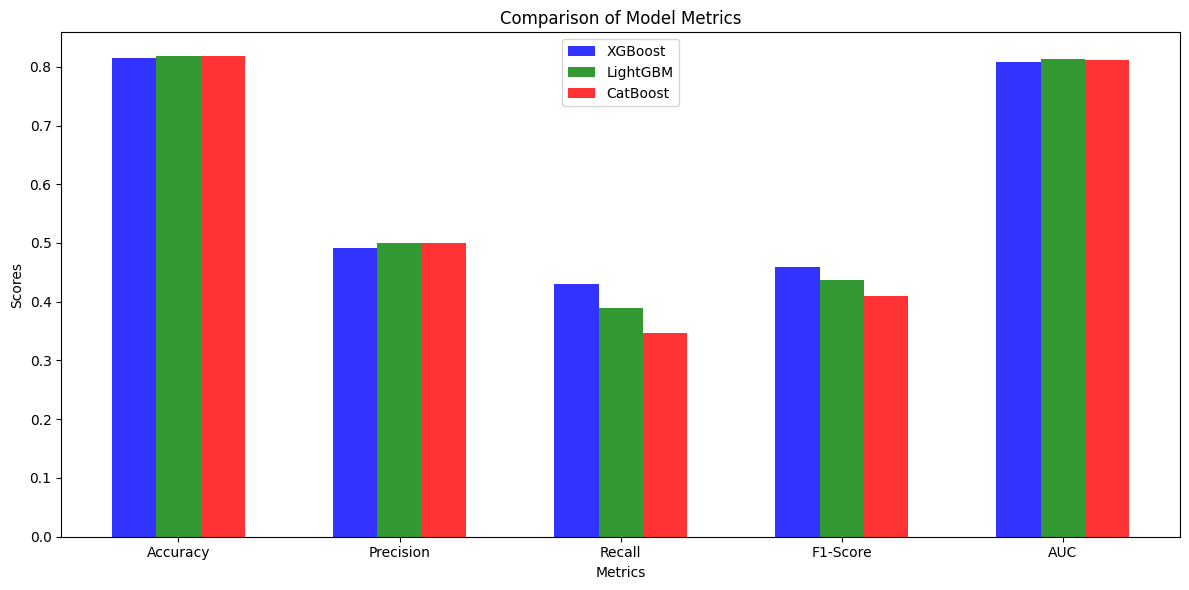

In [95]:
metric_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']
n_groups = len(metric_names)

fig, ax = plt.subplots(figsize=(12, 6))

index = np.arange(n_groups)
bar_width = 0.2
opacity = 0.8

rects1 = ax.bar(index, metrics_xgb, bar_width, alpha=opacity, color='b', label='XGBoost')
rects2 = ax.bar(index + bar_width, metrics_lgb, bar_width, alpha=opacity, color='g', label='LightGBM')
rects3 = ax.bar(index + 2 * bar_width, metrics_cb, bar_width, alpha=opacity, color='r', label='CatBoost')

ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Comparison of Model Metrics')
ax.set_xticks(index + bar_width)
ax.set_xticklabels(metric_names)
ax.legend()

plt.tight_layout()
plt.show()

Let's also see the ROC curves of all 3 models.

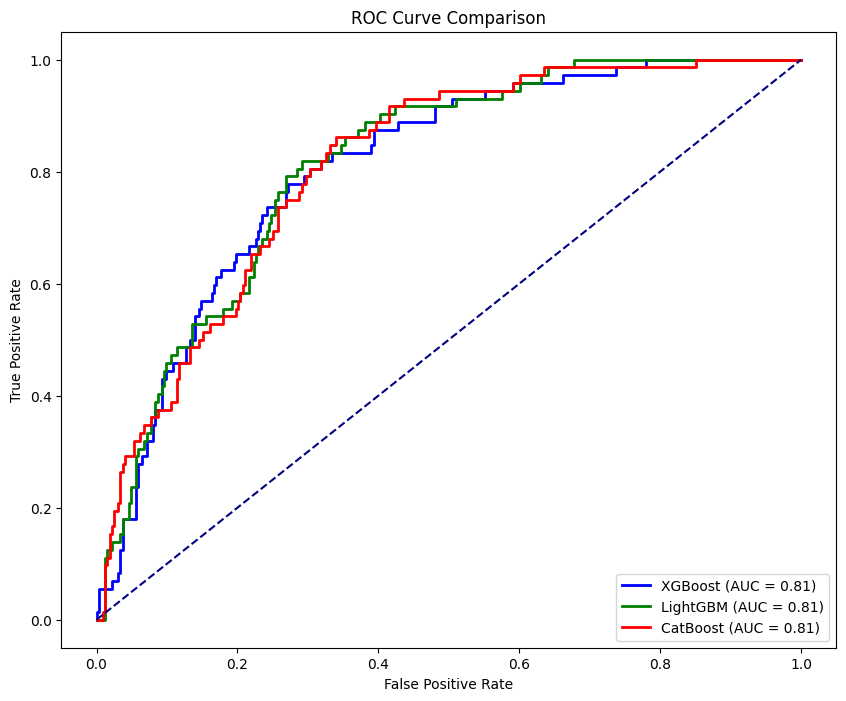

In [96]:
fpr_xgb, tpr_xgb, roc_auc_xgb = roc_data_xgb
fpr_lgb, tpr_lgb, roc_auc_lgb = roc_data_lgb
fpr_cb, tpr_cb, roc_auc_cb = roc_data_cb

plt.figure(figsize=(10, 8))

plt.plot(fpr_xgb, tpr_xgb, color='blue', lw=2, label=f'XGBoost (AUC = {roc_auc_xgb:.2f})')
plt.plot(fpr_lgb, tpr_lgb, color='green', lw=2, label=f'LightGBM (AUC = {roc_auc_lgb:.2f})')
plt.plot(fpr_cb, tpr_cb, color='red', lw=2, label=f'CatBoost (AUC = {roc_auc_cb:.2f})')

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
plt.show()

We can see that eventhough they all have the same AUC scores, their curves aren't the same.